In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 28.0 MB/s eta 0:00:00


In [2]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9649ec9d41eb1ed16be1a364dc5aa7391985b611bca960fdfbe8ad824a1ed704
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=29c3fde0508d8ff999f76fde9288b3b167a080cdc600dde7ad975b53c8ae24ed
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
import imageio
import scipy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics import StructuralSimilarityIndexMeasure
import torch.optim as optim
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones

In [5]:
def lu_chipman(M):
  #Identidades
  I2 = np.stack([np.stack([np.identity(2)]*M.shape[1])]*M.shape[0])
  I3 = np.stack([np.stack([np.identity(3)]*M.shape[1])]*M.shape[0])

  #Normalización
  M_norm = M.copy()
  for i in range(3):
    for j in range(3):
      M_norm[:,:,i,j] = M[:,:,i,j]/M[:,:,0,0]

  #M Diatenuación
  MD = np.ones_like(M)
  MD_inv = np.ones_like(M)
  D = M_norm[:,:,0,1:]
  D2 = np.einsum('ijk,ijk->ij',D, D)
  a = np.sqrt(1-D2,out=np.zeros_like(D2),where=D2<=1)
  b = np.divide(1-a,D2,out=np.zeros_like(D2),where=D2!=0)
  MD[:,:,0,1:] = D
  MD[:,:,1:,0] = D
  for i in range(2):
    for j in range(2):
      MD[:,:,1+i,1+j] = a*I2[:,:,i,j] + b*np.einsum('ijk,ijl->ijkl',D,D)[:,:,i,j]

  #M Prima
  Mprima = np.einsum('ijkl,ijlm->ijkm',M_norm[:,:,:,:],np.linalg.pinv(MD))
  mprima = Mprima[:,:,1:,1:]

  #M Delta
  mdr = np.einsum('ijkl,ijlm->ijkm',mprima,mprima.transpose(0,1,3,2))
  L, V = np.linalg.eig(mdr)

  #Depolarizancia
  delta = np.sqrt(np.abs(L[:,:,0])) * (L[:,:,0] >= L[:,:,1]) + np.sqrt(np.abs(L[:,:,1])) * (L[:,:,0] < L[:,:,1])
  MDelta = np.zeros_like(M)
  MDelta[:,:,0,0] = np.ones(M[:,:,0,0].shape)
  MDelta[:,:,1,1] = delta
  MDelta[:,:,2,2] = delta

  #Polarizancia:
  PDelta = np.zeros((M.shape[0],M.shape[1],2))
  for i in range(2):
    PDelta[:,:,i] = (M_norm[:,:,1+i,0] - np.einsum('ijkl,ijl->ijk',M_norm[:,:,1:,1:],D)[:,:,i])/(1-D2)
  MDelta[:,:,1:,0] = PDelta

  #M Retardancia
  MR = np.einsum('ijkl,ijlm->ijkm', np.linalg.pinv(MDelta), Mprima)

  return MDelta, MR, MD, M[:,:,0,0]

def linear_retardance(M_R):
  delta = np.arccos(np.sqrt((M_R[:,:,1,1]+M_R[:,:,2,2])**2+(M_R[:,:,2,1]-M_R[:,:,1,2])**2)-1)
  return delta

def calcular_mueller_inv(S_in_stat_inv,S_out_stat):
  M = np.einsum('ijklm,ijkmn->ijkln',S_out_stat,S_in_stat_inv)
  return M

def calcular_stokes (I90, I45, I135, I0, A = None, decimador = 1):

  #Decimador
  I0 = I0[::decimador,::decimador]
  I45 = I45[::decimador,::decimador]
  I90 = I90[::decimador,::decimador]
  I135 = I135[::decimador,::decimador]

  #Modo sin calibración
  if A == None:

    #Calculo
    S0 = I0.astype(np.int16)+I90.astype(np.int16)
    S1 = I0.astype(np.int16)-I90.astype(np.int16)
    S2 = I45.astype(np.int16)-I135.astype(np.int16)

  #Modo calibrado
  else:

    #Decimador
    A = A[::decimador,::decimador]
    A = A[::decimador,::decimador]
    A = A[::decimador,::decimador]
    A = A[::decimador,::decimador]

    #Calculo
    S0 = A[:,:,:,0,0]*I0.astype(float)+A[:,:,:,0,1]*I45.astype(float)+A[:,:,:,0,2]*I90.astype(float)+A[:,:,:,0,3]*I135.astype(float)
    S1 = A[:,:,:,1,0]*I0.astype(float)+A[:,:,:,1,1]*I45.astype(float)+A[:,:,:,1,2]*I90.astype(float)+A[:,:,:,1,3]*I135.astype(float)
    S2 = A[:,:,:,2,0]*I0.astype(float)+A[:,:,:,2,1]*I45.astype(float)+A[:,:,:,2,2]*I90.astype(float)+A[:,:,:,2,3]*I135.astype(float)

  #Resultado
  stokes = [S0, S1, S2]

  return stokes

def normalizar_mueller(M):
  # Matriz normalizada
  M_norm = M.copy()

  # Dimensiones
  l, m, n = M.shape[2], M.shape[3], M.shape[4]

  for i in range(m):
    for j in range(n):
      for k in range(l):
        M_norm[:,:,k,i,j] = M_norm[:,:,k,i,j]/M[:,:,k,0,0]

  return M_norm, M[:,:,:,0,0]

def acoplar_matriz(M):
    # Número de filas de la matriz M
    filas = M.shape[3]
    N = M.shape[4]

    # Crear una lista para almacenar las matrices acopladas horizontalmente
    matrices_acopladas = []

    # Acoplar horizontalmente cada matriz individual
    for i in range(filas):
        matriz_i = M[:,:,:,i,0].copy()
        for j in range(1, N):
            matriz_i = np.append(matriz_i, M[:,:,:,i,j], axis=1)
        matrices_acopladas.append(matriz_i)

    # Acoplar verticalmente todas las matrices acopladas horizontalmente
    M_show = np.concatenate(matrices_acopladas, axis=0)

    return M_show

def desacoplar_matriz(A_show, dim = (1024,1224)):

  #Numero de Vectores
  M = A_show.shape[0]//dim[0]

  #Numero de Vectores
  N = A_show.shape[1]//dim[1]

  #Matriz de Mueller
  A = np.zeros((dim[0],dim[1],3,M,N), dtype=float)

  #Desacoplado
  for i in range(M):
    for j in range(N):
      for k in range(3):
        A[:,:,k,i,j] = A_show[i*dim[0]:(i+1)*dim[0],j*dim[1]:(j+1)*dim[1],k]

  return A

def mean_matriz(A):
  M = A.shape[3]
  N = A.shape[4]
  A_mean = np.zeros((M, N))
  A_std = np.zeros((M, N))
  for i in range(M):
    for j in range(N):
      A_mean[i,j] = np.mean(A[:,:,:,i,j])
      A_std[i,j] = np.std(A[:,:,:,i,j])
  for j in range(N):
    A_mean[:,j] = A_mean[:,j]/A_mean[0,j]
  print('Mean: \n', np.round(A_mean,2))
  print('')
  print('STD: \n', np.round(A_std,1))
  print('')
  return A_mean

# Lu Chipman con TorchVision

In [33]:
# Cargar la imagen S_in.png
I_in = desacoplar_matriz(cv2.imread('/content/drive/MyDrive/I_in.png'))

# Cargar la imagen S_out.png
I_out = desacoplar_matriz(cv2.imread('/content/drive/MyDrive/I_out.png'))

# Stokes
N_list = 3
S_in = np.zeros((1024,1224,3,3,N_list),dtype=float)
S_out = np.zeros((1024,1224,3,3,N_list),dtype=float)

# Entrada
S_in[:,:,:,0,:], S_in[:,:,:,1,:], S_in[:,:,:,2,:] = calcular_stokes(I_in[:,:,:,2,:], I_in[:,:,:,1,:], I_in[:,:,:,3,:], I_in[:,:,:,0,:])

# Salida
S_out[:,:,:,0,:], S_out[:,:,:,1,:], S_out[:,:,:,2,:] = calcular_stokes(I_out[:,:,:,2,:], I_out[:,:,:,1,:], I_out[:,:,:,3,:], I_out[:,:,:,0,:])

# Media
S_in_mean = mean_matriz(S_in)

# Inversa
S_in_mean_inv = np.linalg.pinv(S_in_mean)

# Num. Cond.
print('Número de Condición:', np.linalg.cond(S_in_mean))

# Matriz de entrada imagen
S_in_inv = np.zeros((1024,1224,3,S_in.shape[4],S_in.shape[3]))

# Operación vectorizada en lugar de bucles anidados
S_in_inv[:, :, :, :, :] = S_in_mean_inv[np.newaxis, np.newaxis, np.newaxis, :, :]

#Calculo de Mueller
time_1 = time.time()
M = calcular_mueller_inv(S_in_inv,S_out)
M_norm, m00 = normalizar_mueller(M)

# Parámetros Lu-Chipman
LR = np.zeros((3,1024,1224))
for k in range(3):
  _, MR, _, _ = lu_chipman(M_norm[:,:,k,:,:])
  LR[k,:,:] = linear_retardance(MR)
time_1 = time.time() - time_1

print(f'\nTiempo total de ejecución: {time_1:.4f} segundos')

Mean: 
 [[ 1.    1.    1.  ]
 [-0.69 -0.13  0.88]
 [ 0.51 -0.79  0.28]]

STD: 
 [[31.5 34.  30.6]
 [21.9  5.5 27.4]
 [16.3 26.3  9.4]]

Número de Condición: 1.764686966755462

Tiempo total de ejecución: 48.0529 segundos


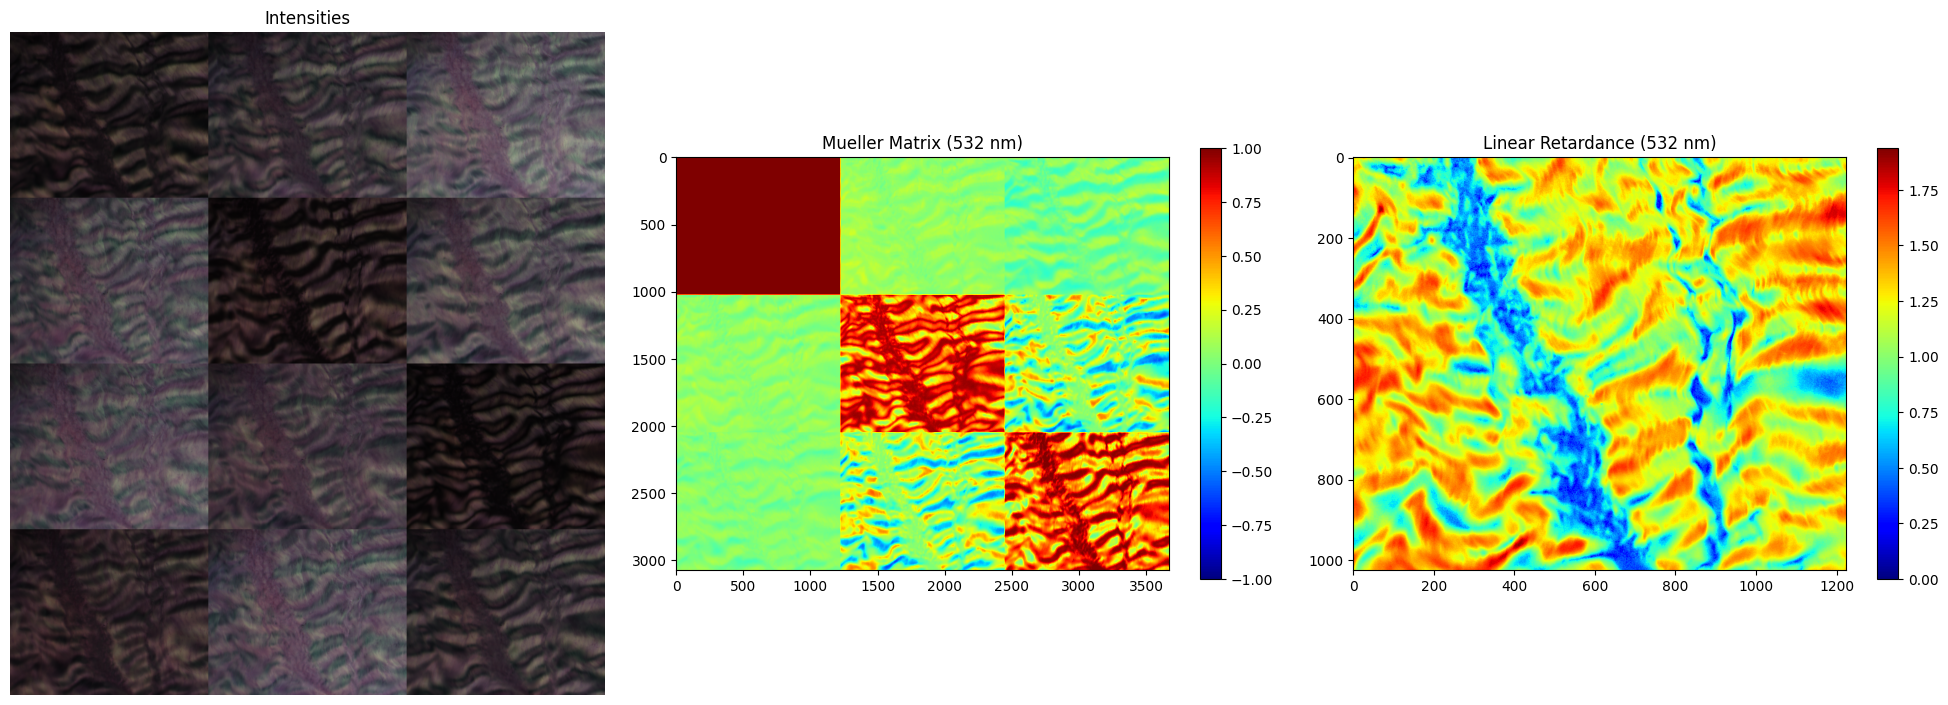

In [ ]:
# Crear la figura y los subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

axes[0].imshow(acoplar_matriz(I_out).astype(np.uint8))
axes[0].set_title("Intensities")
axes[0].axis('off')  # Ocultar los ejes si no son necesarios

im2 = axes[1].imshow(acoplar_matriz(M_norm)[:, :, 1], cmap='jet', vmin=-1, vmax=1)
axes[1].set_title("Mueller Matrix (532 nm)")
fig.colorbar(im2, ax=axes[1], shrink = 0.65)

im3 = axes[2].imshow(LR[1,:,:], cmap='jet', vmin=0)
axes[2].set_title("Linear Retardance (532 nm)")
fig.colorbar(im3, ax=axes[2], shrink = 0.65)

plt.tight_layout()
plt.show()


In [7]:
#Configuración
num_channels = 12
num_parameters = 1

# Tensor
I_out_tensor = torch.tensor(I_out).permute(2, 3, 4, 0, 1).reshape(num_channels, 3, 1024, 1224)

# Tensor shape
print(f"I_out_tensor shape: {I_out_tensor.shape}")

# Tamaño del recorte
crop_size = (64, 64)

# Número de recortes sin solapamiento
num_crops_x = I_out_tensor.shape[2] // crop_size[0]
num_crops_y = I_out_tensor.shape[3] // crop_size[1]
num_crops = num_crops_x * num_crops_y * 3

# Tensor para input_stokes
stokes_images = torch.empty((num_crops, num_channels, *crop_size), dtype=torch.uint8)
parameter_images = torch.empty((num_crops, num_parameters, *crop_size), dtype=torch.float32)

# Recortes sin solapamiento
index = 0
for k in range(3):
  for i in range(num_crops_x):
      for j in range(num_crops_y):
          x = i * crop_size[0]
          y = j * crop_size[1]
          stokes_images[index] = I_out_tensor[:, k, x:x + crop_size[0], y:y + crop_size[1]]
          parameter_images[index, 0] = torch.tensor(LR[k, x:x + crop_size[0], y:y + crop_size[1]], dtype=torch.float32)
          index += 1

# Confirmar tamaños
print(f"stokes_images shape: {stokes_images.shape}")
print(f"parameter_images shape: {parameter_images.shape}")


I_out_tensor shape: torch.Size([12, 3, 1024, 1224])
stokes_images shape: torch.Size([912, 12, 64, 64])
parameter_images shape: torch.Size([912, 1, 64, 64])


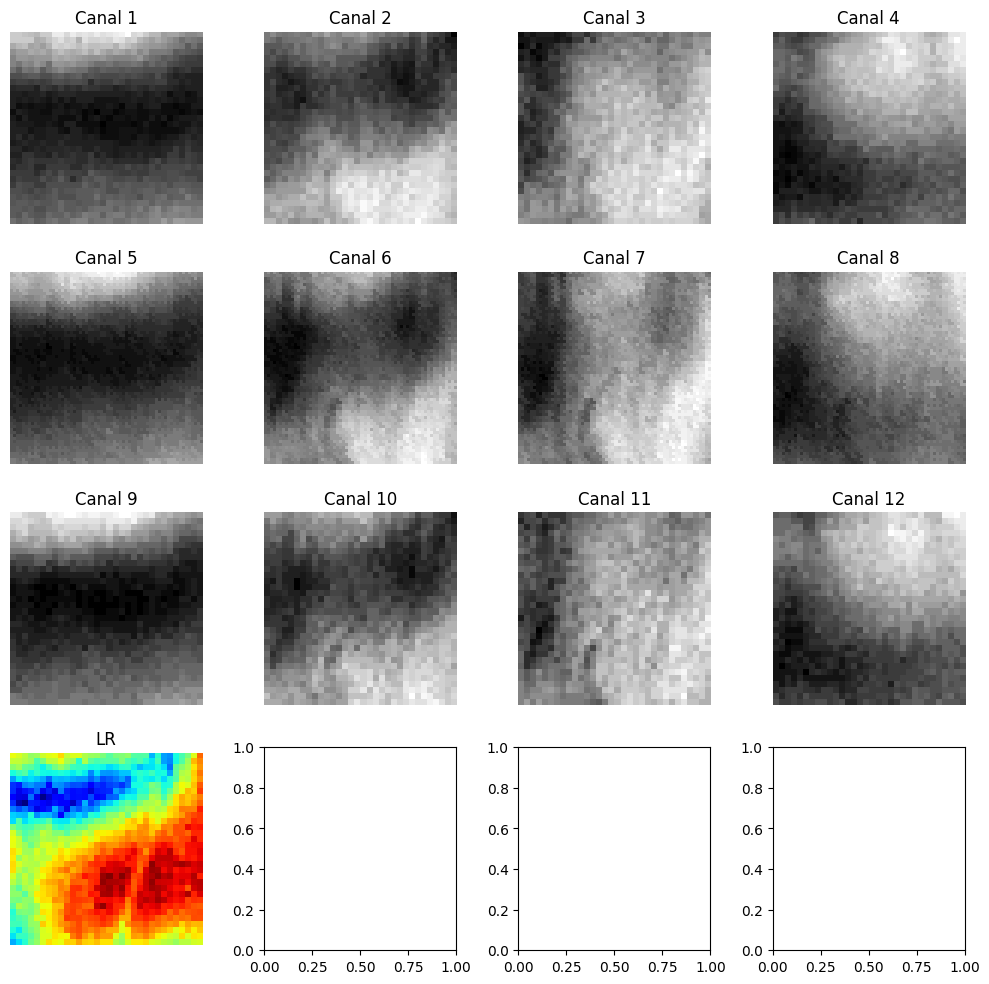

In [ ]:
# Lista de parámetros
params_list = ['LR']

# Ejemplo
example_index = np.random.randint(100) # Cambia esto si deseas otro ejemplo

# Figuras y subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Input intensities
for i in range(12):
    axs[i // 4, i % 4].imshow(stokes_images[example_index, i], cmap='gray')
    axs[i // 4, i % 4].set_title(f'Canal {i+1}')
    axs[i // 4, i % 4].axis('off')  # Ocultar los ejes

# Parámetros
for j in range(num_parameters):
    axs[3, j].imshow(parameter_images[example_index, j], cmap='jet')
    axs[3, j].set_title(params_list[j])
    axs[3, j].axis('off')  # Ocultar los ejes

plt.tight_layout()
plt.show()

In [8]:
class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Mueve SSIM al dispositivo

    def forward(self, output, target):
        ssim_loss = 1 - self.ssim(output, target)
        return ssim_loss

class CustomDataset(Dataset):
    def __init__(self, stokes_images, parameter_images):
        self.stokes_min = stokes_images.min()
        self.stokes_max = stokes_images.max()
        self.param_min = parameter_images.min()
        self.param_max = parameter_images.max()
        self.stokes_images = self.normalize_images(stokes_images, self.stokes_min, self.stokes_max)
        self.parameter_images = self.normalize_images(parameter_images, self.param_min, self.param_max)

    def normalize_images(self, images, min_val, max_val):
        images = torch.tensor(images, dtype=torch.float32)
        return (images - min_val) / (max_val - min_val)

    def __len__(self):
        return len(self.stokes_images)

    def __getitem__(self, idx):
        stokes_image = self.stokes_images[idx]
        parameter_image = self.parameter_images[idx]
        return torch.tensor(stokes_image), torch.tensor(parameter_image)

In [19]:
# CPU o GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# UNet pre-entrenada
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=num_channels,
    classes=num_parameters,
    activation='sigmoid',
).to(device)

In [18]:
# Tensorboard
log_folder = "torchlogs/model"
writer = SummaryWriter("torchlogs/")
writer.close()

In [20]:
# Tensorboard
writer = SummaryWriter(log_folder)

# Definir dataset completo
dataset = CustomDataset(stokes_images, parameter_images)

# Definir conjunto de prueba
test_size = int(0.2 * len(dataset))
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_val_size, test_size])

# DataLoader prueba
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Modelo, optimizador y Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
ssim_criterion = SSIMLoss()
mse_criterion = nn.MSELoss()

# Validación cruzada
k_folds = 10
num_epochs = 50
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Métricas
all_train_losses, all_train_ssims, all_val_ssims = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(range(train_val_size))):
    # Dataset
    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)
    train_dataloader = DataLoader(train_subset, batch_size=1024, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=1024, shuffle=False)

    # Métricas
    fold_train_losses, fold_train_ssims, fold_val_ssims = [], [], []

    print(f'\n--- Fold {fold+1}/{k_folds} ---')

    # Épocas
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_ssim = 0

        # Entrenamiento
        for intensities, properties in train_dataloader:
            intensities, properties = intensities.to(device).float(), properties.to(device).float()
            optimizer.zero_grad()
            output = model(intensities)

            # Loss MSE y métrica SSIM
            loss = mse_criterion(output, properties)
            ssim = 1 - ssim_criterion(output, properties)

            # Backpropagation y optimización
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_ssim += ssim.item()

        # Loss y SSIM Train
        train_loss /= len(train_dataloader)
        train_ssim /= len(train_dataloader)
        fold_train_losses.append(train_loss)
        fold_train_ssims.append(train_ssim)

        # Validación
        model.eval()
        val_ssim = 0
        with torch.no_grad():
            for intensities, properties in val_dataloader:
                intensities, properties = intensities.to(device).float(), properties.to(device).float()
                output = model(intensities)
                ssim = 1 - ssim_criterion(output, properties)
                val_ssim += ssim.item()

        # SSIM promedio validación
        val_ssim /= len(val_dataloader)
        fold_val_ssims.append(val_ssim)

        # Mostrar métricas de la época
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train SSIM: {train_ssim:.4f}, Val SSIM: {val_ssim:.4f}')

        # Cada 5 épocas registrar en tensorboard
        if epoch % 5 == 0:
          writer.add_scalar('Train Loss', train_loss)
          writer.add_scalar('Train SSIM', train_ssim)
          writer.add_scalar('Validation SSIM', val_ssim)

    # Almacenar métricas por fold
    all_train_losses.append(fold_train_losses)
    all_train_ssims.append(fold_train_ssims)
    all_val_ssims.append(fold_val_ssims)

# Prueba
model.eval()
test_ssim = 0
with torch.no_grad():
    for intensities, properties in test_dataloader:
        intensities, properties = intensities.to(device).float(), properties.to(device).float()
        output = model(intensities)
        ssim = 1 - ssim_criterion(output, properties)
        test_ssim += ssim.item()

test_ssim /= len(test_dataloader)

print(f'\nFinal Test SSIM: {test_ssim:.4f}')

<ipython-input-8-c002cce90635>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)



--- Fold 1/10 ---


<ipython-input-8-c002cce90635>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(stokes_image), torch.tensor(parameter_image)


Epoch [1/50], Train Loss: 0.0523, Train SSIM: 0.0766, Val SSIM: 0.5955
Epoch [2/50], Train Loss: 0.0434, Train SSIM: 0.1083, Val SSIM: 0.5529
Epoch [3/50], Train Loss: 0.0327, Train SSIM: 0.1709, Val SSIM: 0.5041
Epoch [4/50], Train Loss: 0.0269, Train SSIM: 0.2437, Val SSIM: 0.4254
Epoch [5/50], Train Loss: 0.0226, Train SSIM: 0.3264, Val SSIM: 0.3635
Epoch [6/50], Train Loss: 0.0207, Train SSIM: 0.3859, Val SSIM: 0.3201
Epoch [7/50], Train Loss: 0.0195, Train SSIM: 0.4239, Val SSIM: 0.2882
Epoch [8/50], Train Loss: 0.0184, Train SSIM: 0.4471, Val SSIM: 0.2697
Epoch [9/50], Train Loss: 0.0175, Train SSIM: 0.4603, Val SSIM: 0.2624
Epoch [10/50], Train Loss: 0.0167, Train SSIM: 0.4686, Val SSIM: 0.2644
Epoch [11/50], Train Loss: 0.0160, Train SSIM: 0.4731, Val SSIM: 0.2766
Epoch [12/50], Train Loss: 0.0154, Train SSIM: 0.4746, Val SSIM: 0.2892
Epoch [13/50], Train Loss: 0.0148, Train SSIM: 0.4756, Val SSIM: 0.3036
Epoch [14/50], Train Loss: 0.0142, Train SSIM: 0.4781, Val SSIM: 0.3263
E

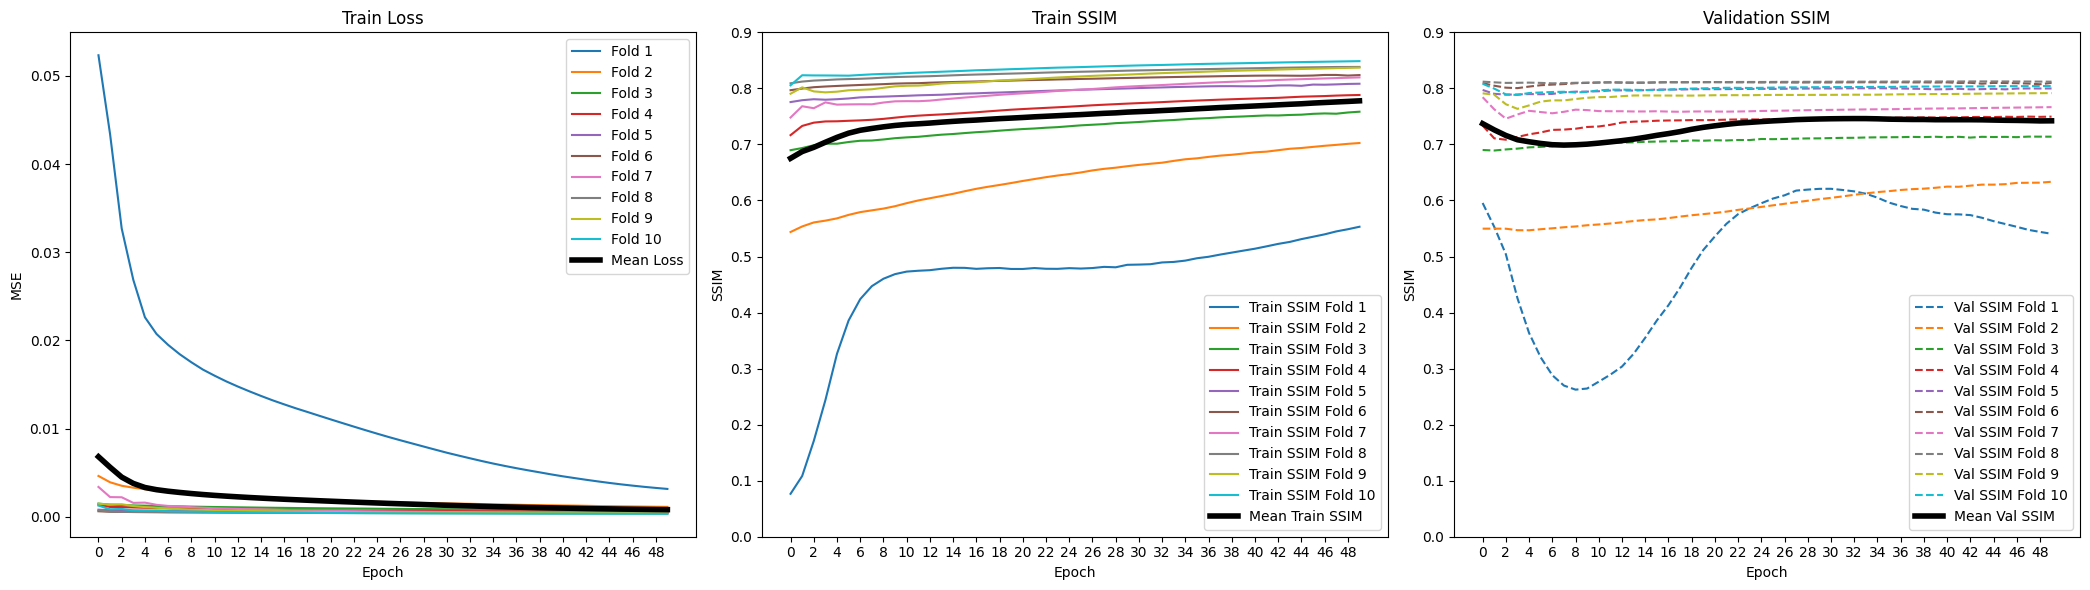

In [31]:
# Promediar métricas para obtener curvas medias sobre los folds
mean_train_losses = np.mean(all_train_losses, axis=0)
mean_train_ssims = np.mean(all_train_ssims, axis=0)
mean_val_ssims = np.mean(all_val_ssims, axis=0)

# Figuras
plt.figure(figsize=(21, 6))

# Loss Train
plt.subplot(1, 3, 1)
for fold_idx, fold_losses in enumerate(all_train_losses):
    plt.plot(fold_losses, label=f'Fold {fold_idx+1}')
plt.plot(mean_train_losses, 'k', label='Mean Loss', linewidth=4)
plt.xticks(np.arange(0,num_epochs,2))
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# SSIM Train y Validación
plt.subplot(1, 3, 2)
for fold_idx, fold_ssim in enumerate(all_train_ssims):
    plt.plot(fold_ssim, label=f'Train SSIM Fold {fold_idx+1}')
plt.plot(mean_train_ssims, 'k', label='Mean Train SSIM', linewidth=4)
plt.title("Train SSIM")
plt.xticks(np.arange(0,num_epochs,2))
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()

plt.subplot(1, 3, 3)

for fold_idx, fold_ssim in enumerate(all_val_ssims):
    plt.plot(fold_ssim, label=f'Val SSIM Fold {fold_idx+1}', linestyle='--')
plt.plot(mean_val_ssims, 'k', label='Mean Val SSIM', linewidth=4)
plt.title("Validation SSIM")
plt.xticks(np.arange(0,num_epochs,2))
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-8-c002cce90635>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(stokes_image), torch.tensor(parameter_image)


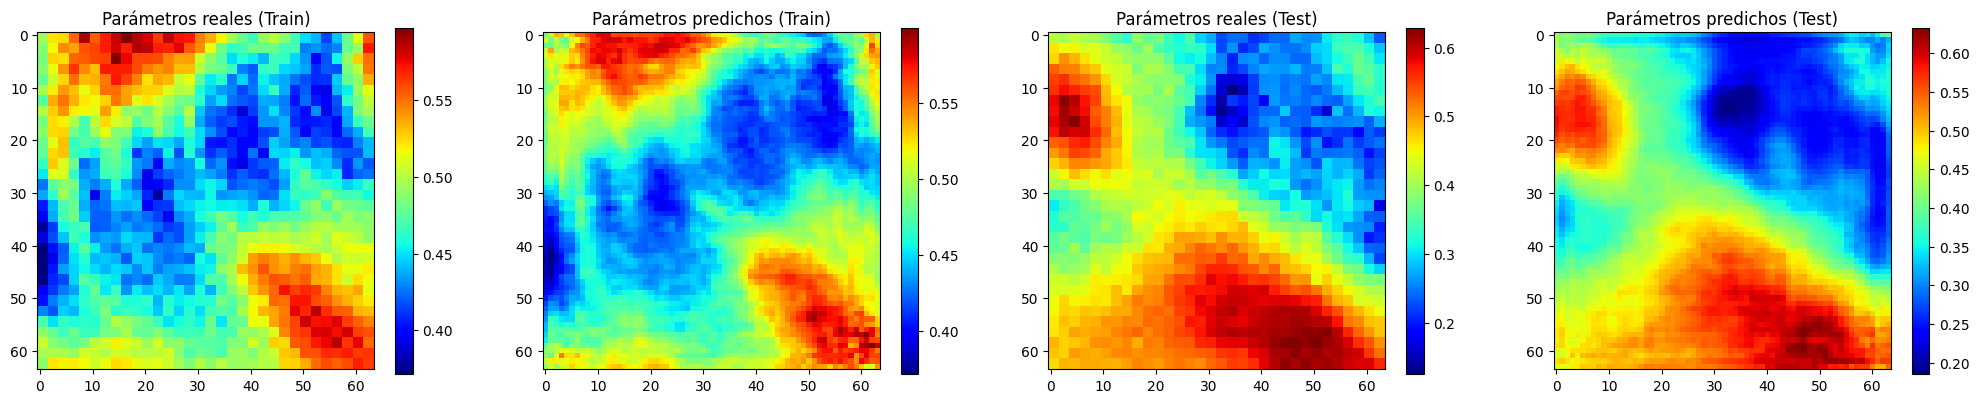

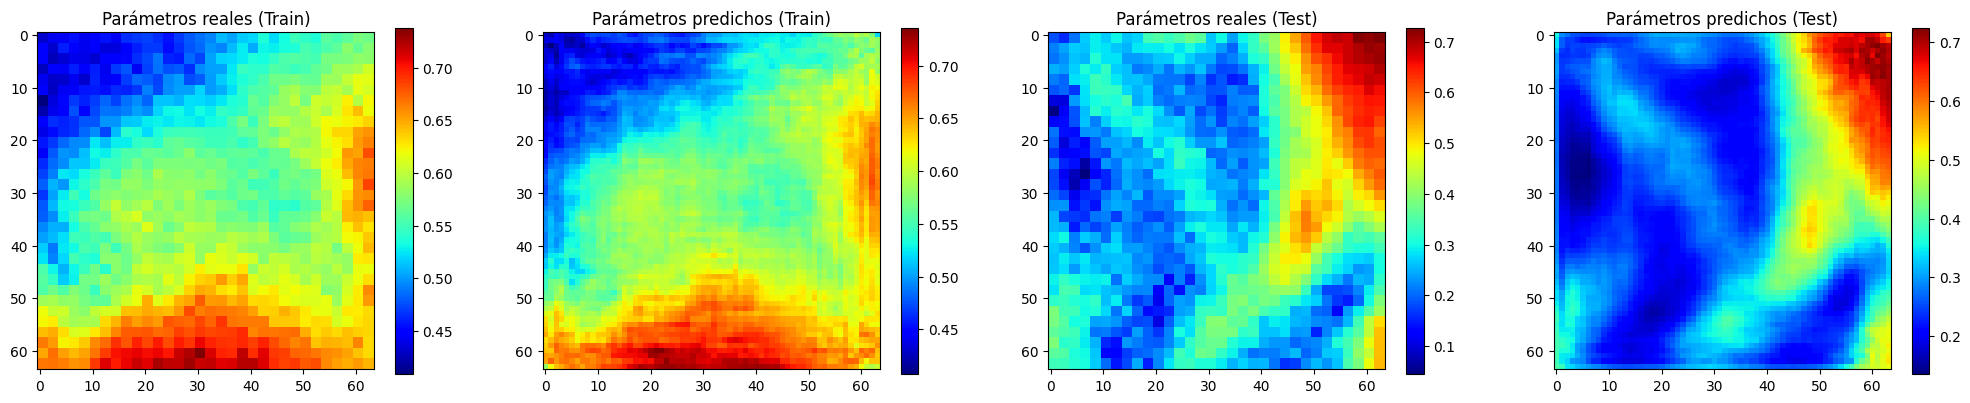

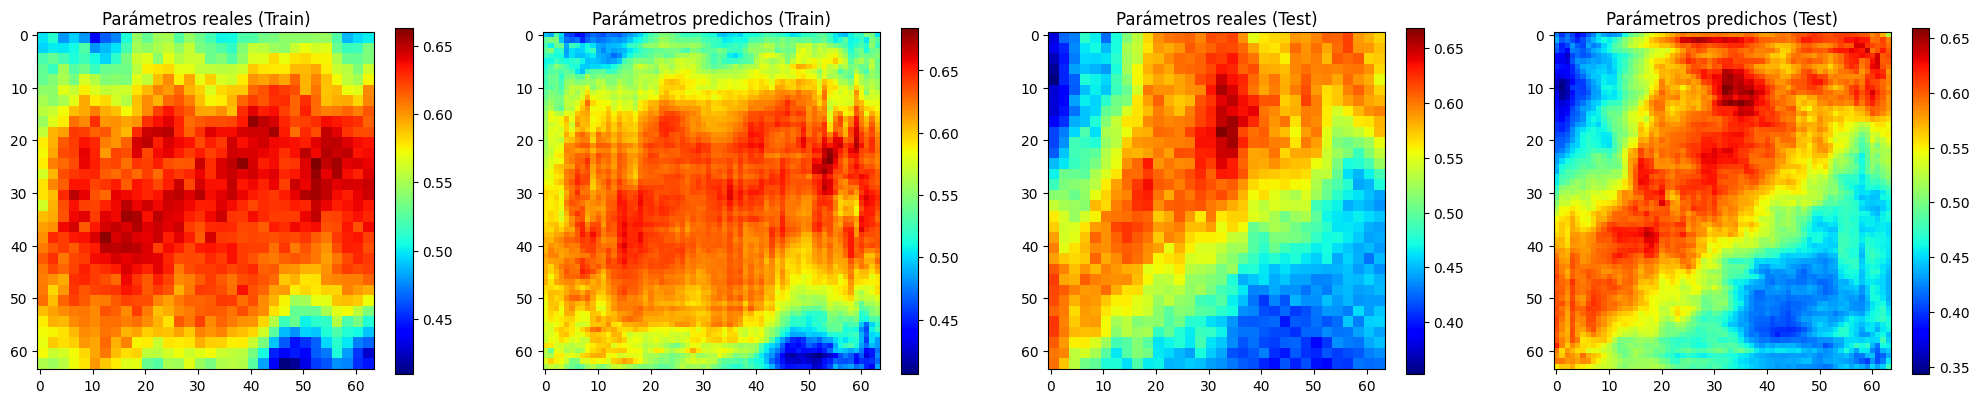

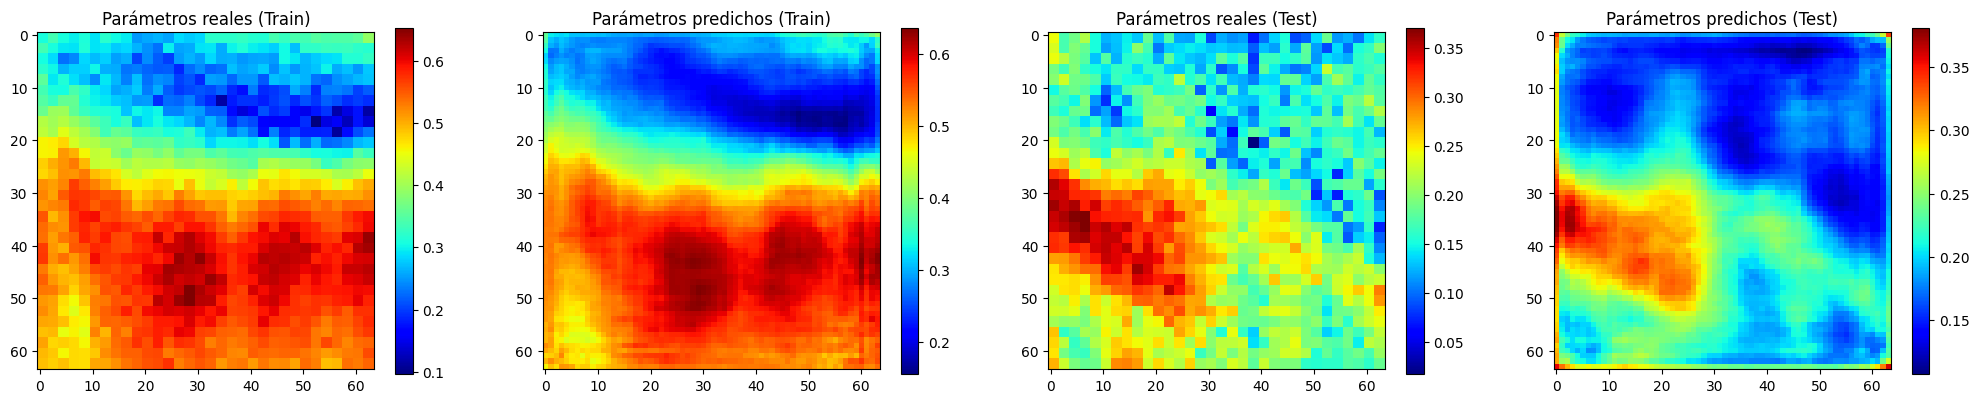

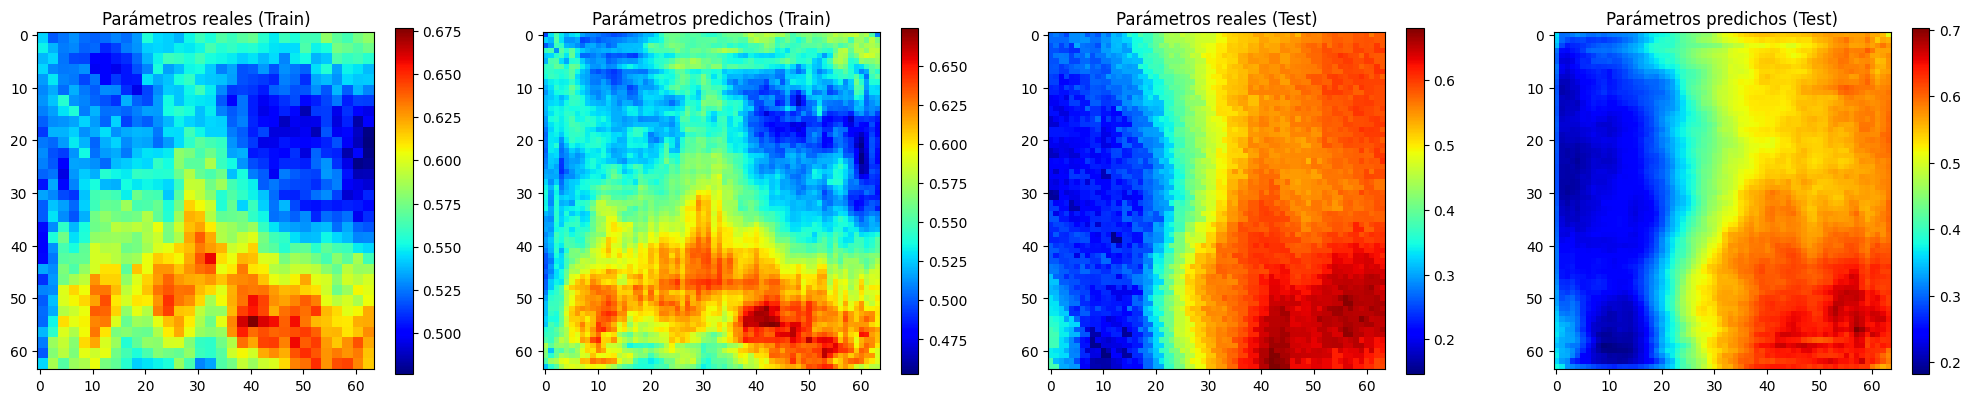

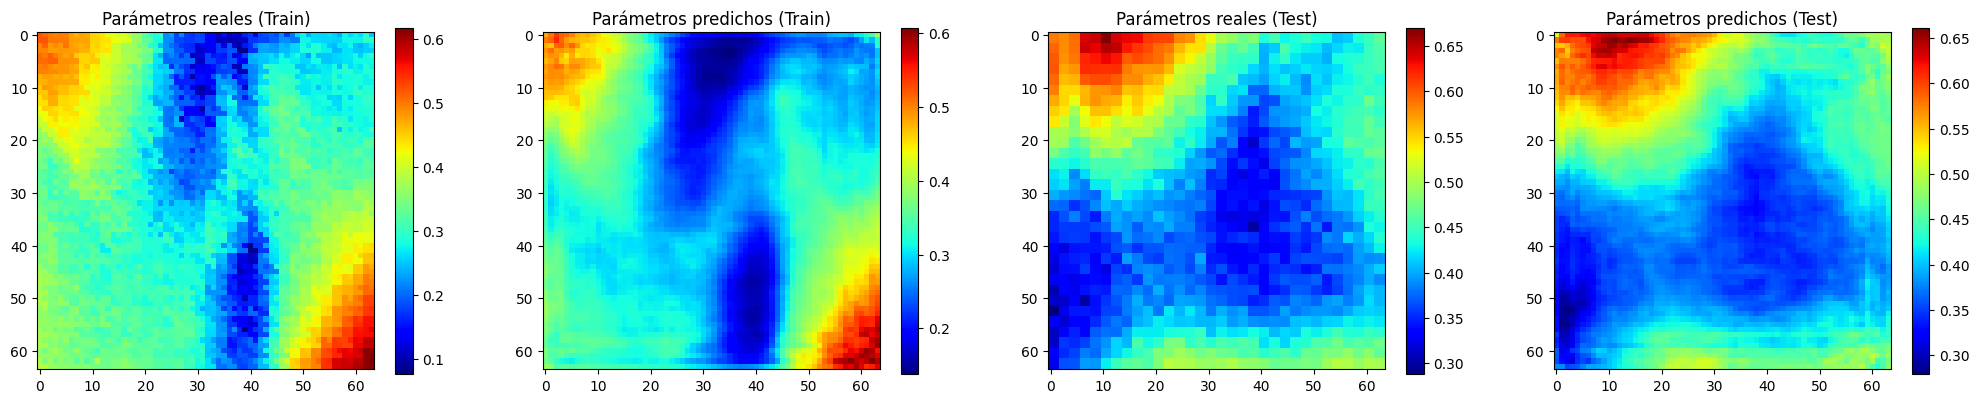

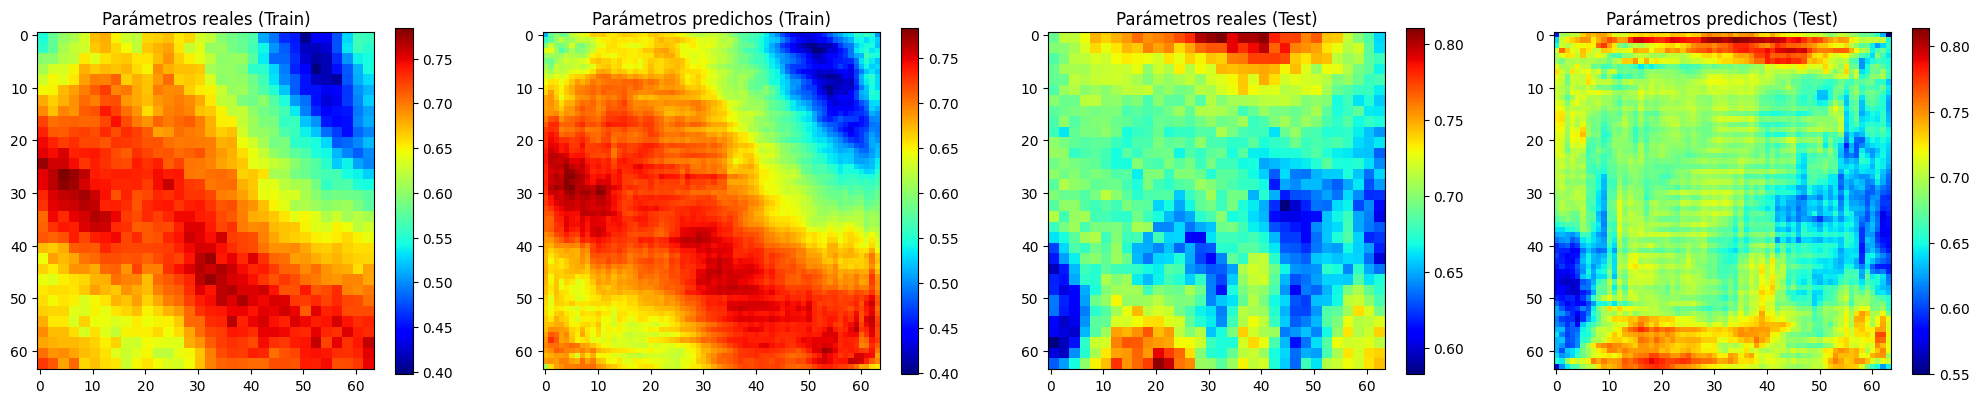

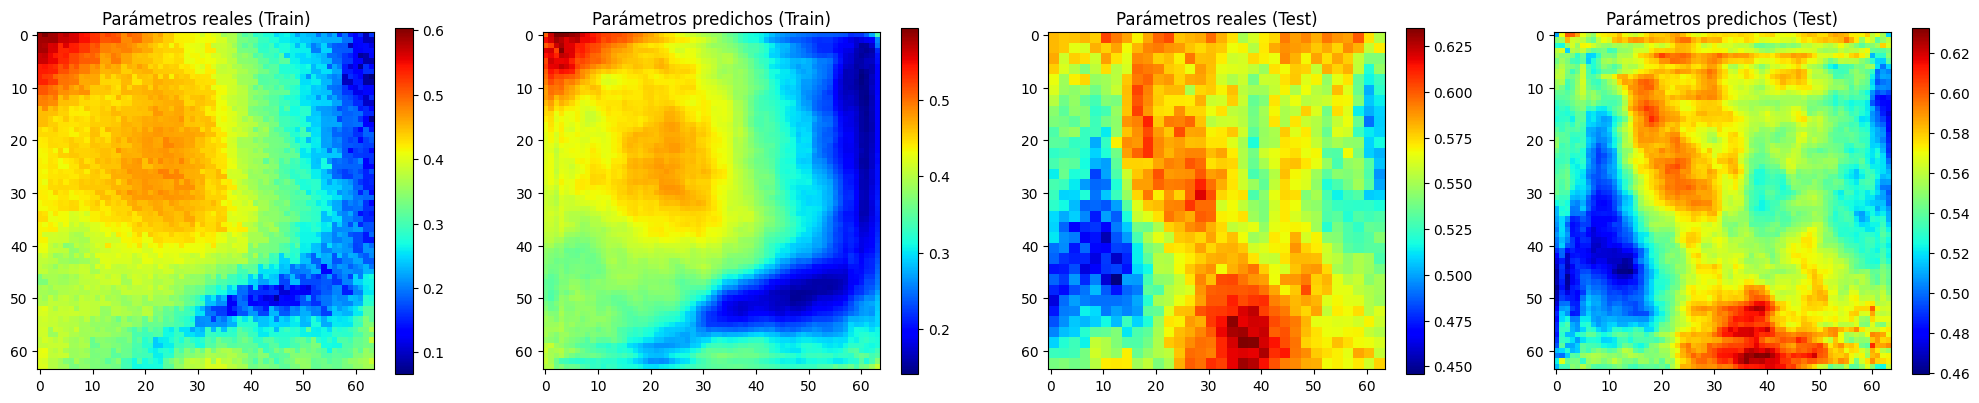

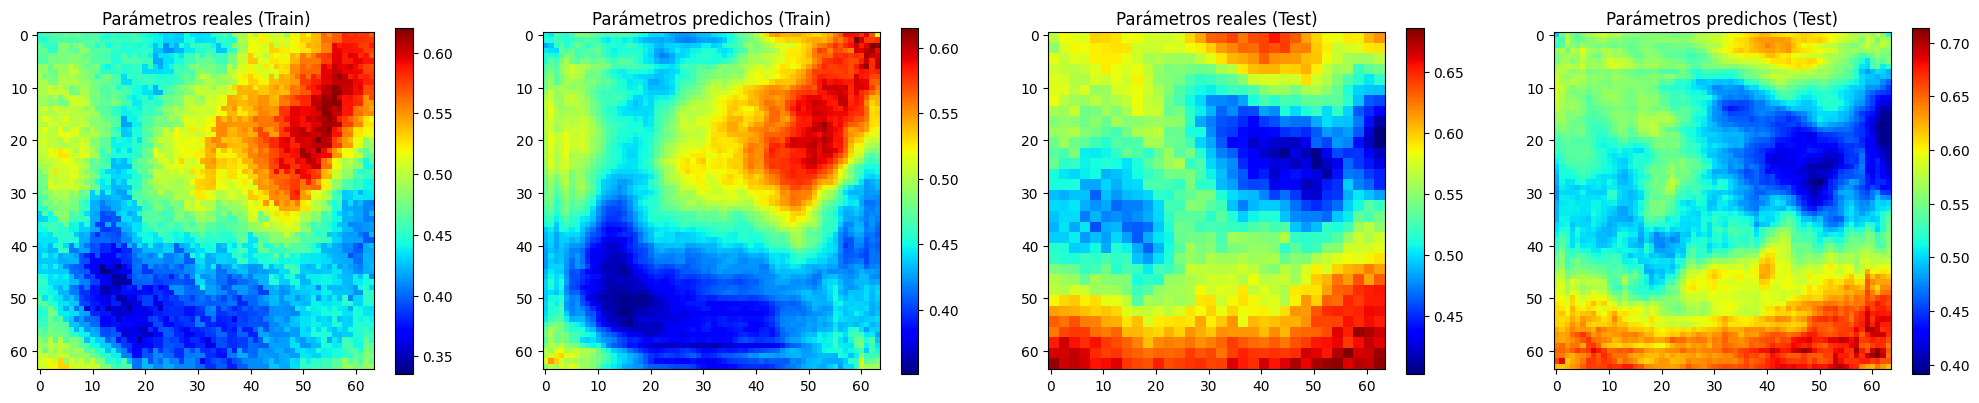

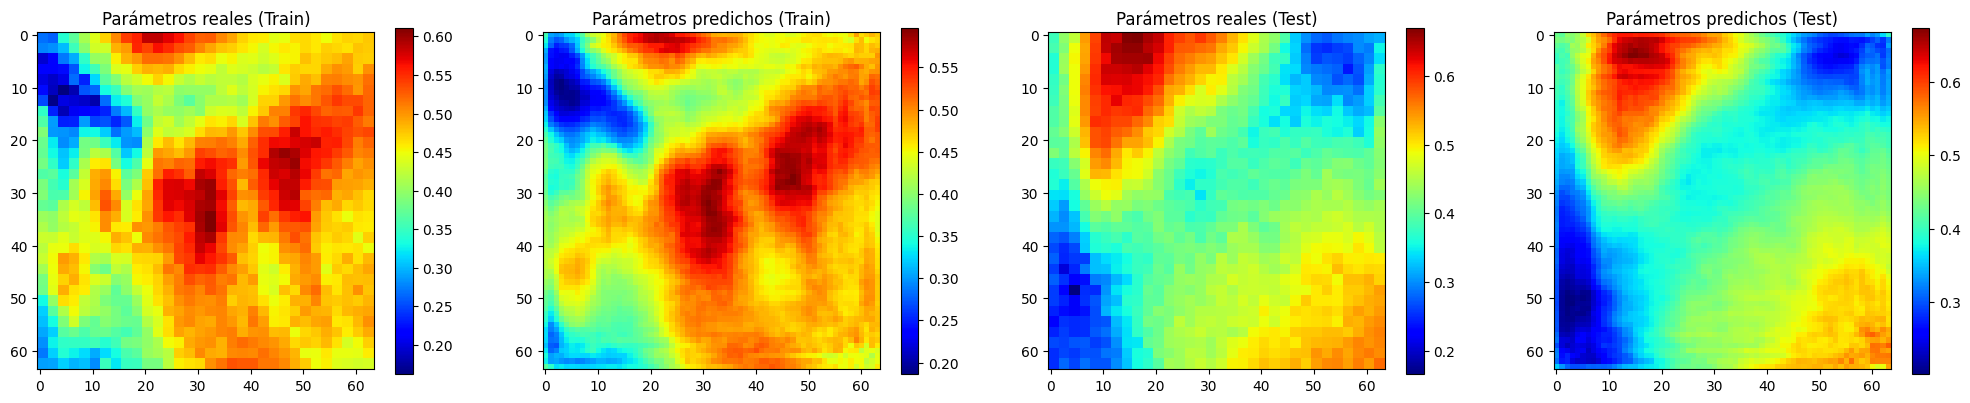


Final Train SSIM: 0.8484

Final Validation SSIM: 0.8041

Final Test SSIM: 0.6643

Tiempo total de ejecución: 0.0300 segundos


In [32]:
# Evaluación final en los conjuntos de entrenamiento, validación y prueba
model.eval()
test_ssim_train = 0
test_ssim_val = 0
test_ssim_test = 0
num_examples = 10  # Número de ejemplos de imágenes que queremos visualizar

with torch.no_grad():
    # Evaluación en el conjunto de entrenamiento
    for (idx_train, (intensities_train, properties_train)) in enumerate(train_dataloader):
        # Mover los datos al dispositivo
        intensities_train, properties_train = intensities_train.to(device).float(), properties_train.to(device).float()

        # Realizar la predicción
        time_1 = time.time()
        output_train = model(intensities_train)
        time_1 = time.time() - time_1

        # Calcular el SSIM para cada lote
        ssim_train = 1 - ssim_criterion(output_train, properties_train)
        test_ssim_train += ssim_train.item()

    # Evaluación en el conjunto de validación
    for (idx_val, (intensities_val, properties_val)) in enumerate(val_dataloader):
        # Mover los datos al dispositivo
        intensities_val, properties_val = intensities_val.to(device).float(), properties_val.to(device).float()

        # Realizar la predicción
        time_2 = time.time()
        output_val = model(intensities_val)
        time_2 = time.time() - time_2

        # Calcular el SSIM para cada lote
        ssim_val = 1 - ssim_criterion(output_val, properties_val)
        test_ssim_val += ssim_val.item()

    # Evaluación en el conjunto de prueba
    for (idx_test, (intensities_test, properties_test)) in enumerate(test_dataloader):
        # Mover los datos al dispositivo
        intensities_test, properties_test = intensities_test.to(device).float(), properties_test.to(device).float()

        # Realizar la predicción
        time_3 = time.time()
        output_test = model(intensities_test)
        time_3 = time.time() - time_3

        # Calcular el SSIM para cada lote
        ssim_test = 1 - ssim_criterion(output_test, properties_test)
        test_ssim_test += ssim_test.item()

        # Mostrar ejemplos de predicción vs. realidad en el primer lote
        if idx_test == 0:
            output_train = output_train.detach().cpu()
            properties_train = properties_train.detach().cpu()
            output_val = output_val.detach().cpu()
            properties_val = properties_val.detach().cpu()
            output_test = output_test.detach().cpu()
            properties_test = properties_test.detach().cpu()

            for k in range(num_examples):
                plt.figure(figsize=(25, 5))

                # Imagen de parámetros reales - entrenamiento
                plt.subplot(1, 4, 1)
                plt.imshow(properties_train[k][0], cmap='jet')
                plt.title("Parámetros reales (Train)")
                plt.colorbar(shrink=0.9)

                # Imagen de parámetros predicha - entrenamiento
                plt.subplot(1, 4, 2)
                plt.imshow(output_train[k][0], cmap='jet')
                plt.title("Parámetros predichos (Train)")
                plt.colorbar(shrink=0.9)

                # Imagen de parámetros reales - validación
                plt.subplot(1, 4, 3)
                plt.imshow(properties_val[k][0], cmap='jet')
                plt.title("Parámetros reales (Test)")
                plt.colorbar(shrink=0.9)

                # Imagen de parámetros predicha - validación
                plt.subplot(1, 4, 4)
                plt.imshow(output_val[k][0], cmap='jet')
                plt.title("Parámetros predichos (Test)")
                plt.colorbar(shrink=0.9)

                plt.show()

# Calcular el SSIM promedio en los conjuntos de entrenamiento, validación y prueba
test_ssim_train /= len(train_dataloader)
print(f'\nFinal Train SSIM: {test_ssim_train:.4f}')

test_ssim_val /= len(val_dataloader)
print(f'\nFinal Validation SSIM: {test_ssim_val:.4f}')

test_ssim_test /= len(test_dataloader)
print(f'\nFinal Test SSIM: {test_ssim_test:.4f}')

total_time = time_1 + time_2 + time_3
print(f'\nTiempo total de ejecución: {total_time:.4f} segundos')